<a href="https://colab.research.google.com/github/anuj0456/deep_learning_for_coders/blob/master/fastai/fastai_lesson3_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

(#5) [Path('/root/.fastai/data/camvid/labels'),Path('/root/.fastai/data/camvid/models'),Path('/root/.fastai/data/camvid/images'),Path('/root/.fastai/data/camvid/valid.txt'),Path('/root/.fastai/data/camvid/codes.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

(#3) [Path('/root/.fastai/data/camvid/images/0016E5_01260.png'),Path('/root/.fastai/data/camvid/images/0016E5_07020.png'),Path('/root/.fastai/data/camvid/images/0006R0_f03390.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

(#3) [Path('/root/.fastai/data/camvid/labels/Seq05VD_f05070_P.png'),Path('/root/.fastai/data/camvid/labels/0006R0_f02520_P.png'),Path('/root/.fastai/data/camvid/labels/0016E5_01050_P.png')]

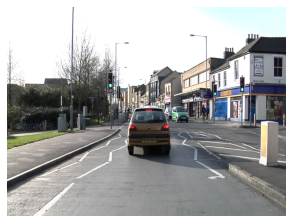

In [7]:
img_f = fnames[0]
img = PILImage.create(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

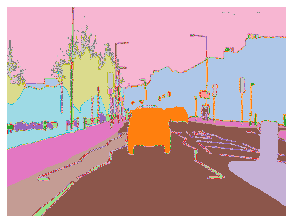

In [9]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,tensor(mask)

(array([960]), tensor([[21, 21, 21,  ..., 21, 21, 21],
         [21, 21, 21,  ..., 21, 21, 21],
         [21, 21, 21,  ..., 21, 21, 21],
         ...,
         [18, 18, 18,  ..., 17, 17, 17],
         [18, 18, 18,  ..., 17, 17, 17],
         [18, 18, 18,  ..., 17, 17, 17]], dtype=torch.uint8))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [12]:
size = src_size//2
bs=8

In [13]:
valid_fnames = (path/'valid.txt').readlines()

In [14]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).readlines()
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [15]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
                   batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)])

In [16]:
dls = camvid.dataloaders(path/"images", bs=8, path=path)

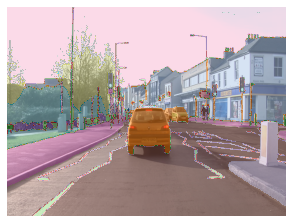

In [17]:
show_at(dls.train_ds, 0)

In [18]:
b = dls.train.one_batch()

In [19]:
b = dls.train.decode(b)

In [20]:
b[0].shape, b[1].shape

((8, 3, 360, 480), (8, 360, 480))

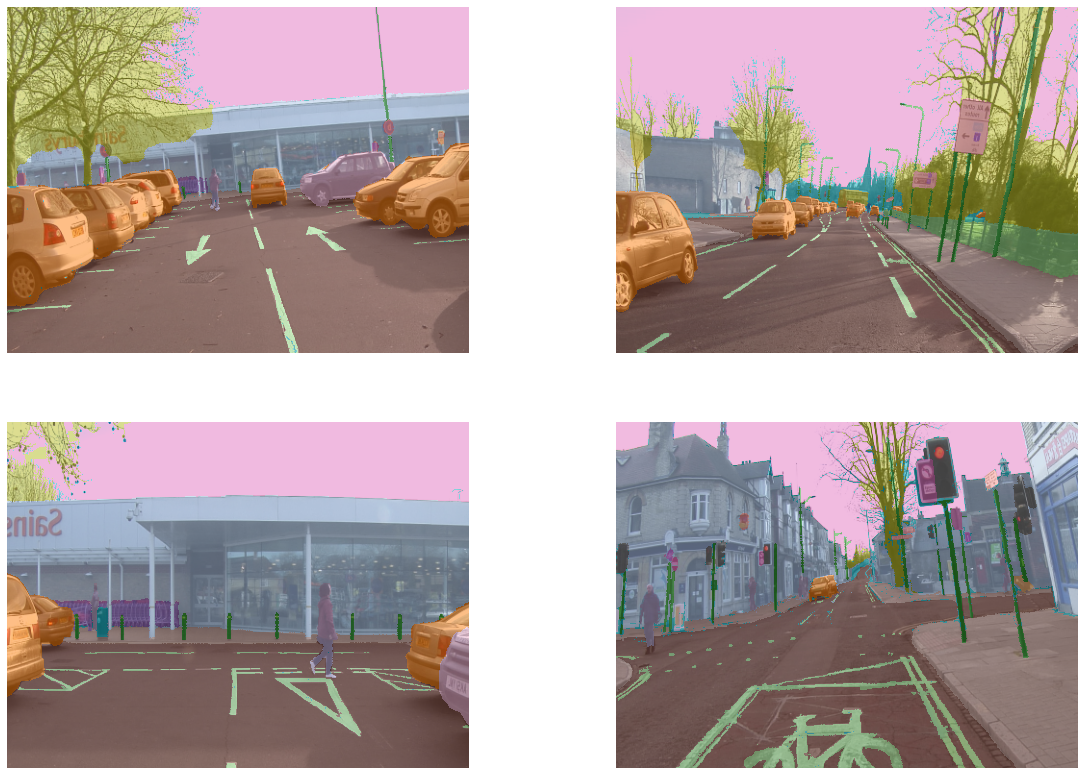

In [21]:
dls.show_batch(max_n=4, figsize=(20,14))

In [22]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [23]:
metrics=acc_camvid

In [24]:
wd=1e-2

In [25]:
dls.vocab = codes

In [26]:
learn = unet_learner(dls, resnet34, metrics=metrics)

In [27]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=0.0002754228771664202)

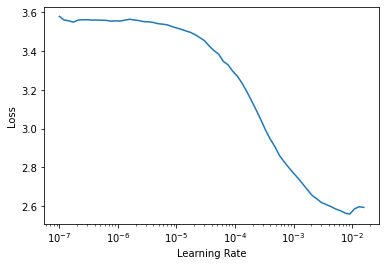

In [28]:
learn.lr_find()

In [30]:
lr=1e-4

In [31]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.633732,None,None,00:56
1,1.575919,None,None,00:56
2,1.085070,None,None,00:56
3,0.811345,None,None,00:56
4,0.689073,None,None,00:56
5,0.597147,None,None,00:56


/usr/local/lib/python3.6/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,acc_camvid,time
0,2.633732,None,None,00:56
1,1.575919,None,None,00:56
2,1.085070,None,None,00:56
3,0.811345,None,None,00:56
4,0.689073,None,None,00:56
5,0.597147,None,None,00:56
6,0.545468,None,None,00:56
7,0.520361,None,None,00:56
8,0.460598,None,None,00:56
9,0.422521,None,None,00:56


In [32]:
learn.save('stage-1')

Path('/root/.fastai/data/camvid/models/stage-1.pth')

In [33]:
learn.load('stage-1');

In [59]:
learn.show_results(max_n=4, figsize=(9,4))

In [36]:
learn.unfreeze()

In [35]:
lrs = slice(lr/400,lr/4)

In [37]:
learn.fit_one_cycle(12, lrs, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.389743,None,None,00:58
1,0.382423,None,None,00:58
2,0.383101,None,None,00:58
3,0.374493,None,None,00:58
4,0.375353,None,None,00:58
5,0.369603,None,None,00:58
6,0.360706,None,None,00:58
7,0.351789,None,None,00:58
8,0.352775,None,None,00:58
9,0.341117,None,None,00:58


/usr/local/lib/python3.6/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [38]:
learn.save('stage-2');

In [39]:
del learn
import gc
gc.collect()

18046

In [42]:
size = src_size
bs=3
#depending on your GPU RAM you may need to use
# bs=1
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [43]:
dls = camvid.dataloaders(path/"images", bs=3, path=path,
                          batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

In [44]:
dls.vocab = codes

In [45]:
learn = unet_learner(dls, resnet34, metrics=metrics)

In [46]:
learn.load('stage-2');

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=3.311311274956097e-06)

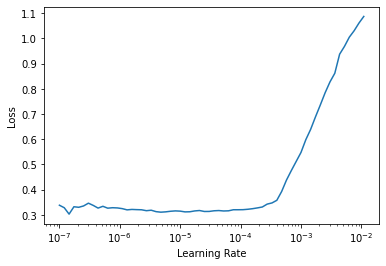

In [47]:
learn.lr_find()

In [48]:
lr=1e-3

In [49]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.381050,None,None,01:03
1,0.463315,None,None,01:03
2,0.522325,None,None,01:04
3,0.496395,None,None,01:04
4,0.506022,None,None,01:03
5,0.473778,None,None,01:03
6,0.428890,None,None,01:03
7,0.417461,None,None,01:03
8,0.362056,None,None,01:04
9,0.289024,None,None,01:04


/usr/local/lib/python3.6/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [50]:
learn.save('stage-1-big')

Path('/root/.fastai/data/camvid/models/stage-1-big.pth')

In [51]:
learn.load('stage-1-big');

In [52]:
learn.unfreeze()

In [53]:
lrs = slice(1e-6,lr/10)

In [54]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.259104,None,None,01:07
1,0.263432,None,None,01:07
2,0.262214,None,None,01:07
3,0.244187,None,None,01:07
4,0.235717,None,None,01:06
5,0.232612,None,None,01:06
6,0.230622,None,None,01:06
7,0.223290,None,None,01:07
8,0.218845,None,None,01:06
9,0.214980,None,None,01:07


/usr/local/lib/python3.6/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [55]:
learn.save('stage-2-big')

Path('/root/.fastai/data/camvid/models/stage-2-big.pth')

In [56]:
learn.load('stage-2-big');

In [58]:
learn.show_results(max_n=1, figsize=(20,10), vmin=1, vmax=30)